# Calculating the Return on Investement for Single-Family Home Sales
For any investment, we want to know how much we can make from the investment. Especially when intrest rates are high, investing in index funds may generate good ROI with low risk. To know if our investment is worth it, we need the following inputs. 

* **Purchase Cost** this is how much we're paying upfront for the properties we're buying.
* **Renovation Cost** this is how much we're spending on upgrades.
* **Holding Cost** while we own the property, how much is it costing us in terms of taxes, utilites, insurance, and upkeep. We will assume a fixed amount per property.
* **Financing Cost** we're making mortage payments while we've the property. How much interest is it costing us?
* **Selling Cost** typically, we would have an broker who takes a commission plus closing costs. Typically, this sets around 3-6% of the sale price.
* **Final Sale Price** how much we're selling each property for.

To acquire those inputs, we will look into the data Zillow provides. We won't find all the data such holding and selling costs, so we will use estimates or use other data sets to acquire those inputs. 

First, we need to build our investment portfolio and we start by identifying high growth markets. 

In [203]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import util
%matplotlib inline     
sns.set(color_codes=True)

## Identifying High Growth Markets
First, we need to identify high growth market where we can have high return on investment. Zillow Home Value Index is a home price estimation from Zillow that we can use to identify high growth markets. So we will use the `ZHVI Single-Family Homes Time Series ($)` dataset. Zillow provides a forecast dataset, but the dataset covers all home types, so we will have to build our own based on the investor intrest.  

First, let's load the data and inspect some top and bottom rows.

In [204]:
# Load the Zillow dataset
df = pd.read_csv('../data/sfh_ts.csv')
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,102001,0,United States,country,NaN,121531.336651,121738.651072,121995.876446,122548.308184,123184.186238,...,350593.674816,351419.563807,352981.682891,354901.213108,356405.219291,357054.866170,357269.495250,357556.470130,358047.728564,358695.400157
1,394913,1,"New York, NY",msa,NY,215526.347853,216437.299774,217353.388393,219206.206623,221115.123983,...,653024.167946,657325.710093,662976.463941,669457.862304,674379.010648,677580.634957,680209.743078,683834.502366,687956.181425,691747.775297
2,753899,2,"Los Angeles, CA",msa,CA,228840.318549,229713.653329,230850.552728,233116.339880,235575.321729,...,961240.278183,958067.128774,956942.083361,960982.286878,967579.982979,972048.452546,976772.555536,982347.195293,989199.485026,994897.480686
3,394463,3,"Chicago, IL",msa,IL,156308.333980,156460.092041,156739.556227,157434.724023,158265.478146,...,323407.920786,325014.621277,327666.811355,330756.679881,333074.201792,334422.582458,335234.282077,336199.561203,337340.532590,338506.114351
4,394514,4,"Dallas, TX",msa,TX,126045.193158,126100.940737,126169.731762,126344.177104,126568.833701,...,371215.184232,371698.224857,372852.439583,373826.243574,373978.341627,373322.949324,372396.923106,371759.173084,371580.012878,371494.296639


In [205]:
df.tail()

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
890,753929,935,"Zapata, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,125505.480365,124620.859170,124703.453283,126217.346418,127940.190271,129029.544547,129216.203575,128841.856015,128169.963134,127248.665154
891,394743,936,"Ketchikan, AK",msa,AK,NaN,NaN,NaN,NaN,NaN,...,411724.194103,411668.716287,413385.593811,415037.934548,416247.744981,416235.514828,415323.647956,415325.998281,416842.773776,419086.682223
892,753874,937,"Craig, CO",msa,CO,98830.861837,99097.911211,99574.805478,100259.229234,101040.616567,...,285287.949217,285219.875814,285685.290380,286463.285398,287357.918108,287698.710801,288033.677233,288266.115146,289594.833055,291259.120524
893,395188,938,"Vernon, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,91184.718655,91281.020656,91975.182494,92739.898571,93395.868423,93641.985168,93402.487663,92893.101563,91612.695630,90013.700765
894,394767,939,"Lamesa, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,88711.311676,87596.741991,87637.262603,87847.018796,88770.521386,90064.663210,91903.350319,93542.740242,94253.311435,94265.128384


From the initial look, we can quickly spot the following
* The data is optimized for size, so each region has a single row and each estimation is a value in a date column.
* We've some null values for older dates in some regions.

In [206]:
# Let's confirm our assumption about "each region is a single row"
df[df.duplicated(subset='RegionID', keep=False)]

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31


In [207]:
# Let's drop any fields we're not going to use. We're keeping RegionID because it's safer to use than RegionName
# which contains white space. Additionally, we will use RegionID to interact with other datasets from Zillow
# we also should keep state names in case we need to deal with aggregate date at state-level
single_home_values = df.drop(columns=['SizeRank', 'RegionType'])
single_home_values.head()

,RegionID,RegionName,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,102001,United States,NaN,121531.336651,121738.651072,121995.876446,122548.308184,123184.186238,123865.680213,124586.279073,...,350593.674816,351419.563807,352981.682891,354901.213108,356405.219291,357054.866170,357269.495250,357556.470130,358047.728564,358695.400157
1,394913,"New York, NY",NY,215526.347853,216437.299774,217353.388393,219206.206623,221115.123983,223259.025429,225613.438183,...,653024.167946,657325.710093,662976.463941,669457.862304,674379.010648,677580.634957,680209.743078,683834.502366,687956.181425,691747.775297
2,753899,"Los Angeles, CA",CA,228840.318549,229713.653329,230850.552728,233116.339880,235575.321729,238017.327535,240515.010731,...,961240.278183,958067.128774,956942.083361,960982.286878,967579.982979,972048.452546,976772.555536,982347.195293,989199.485026,994897.480686
3,394463,"Chicago, IL",IL,156308.333980,156460.092041,156739.556227,157434.724023,158265.478146,159199.059474,160194.910072,...,323407.920786,325014.621277,327666.811355,330756.679881,333074.201792,334422.582458,335234.282077,336199.561203,337340.532590,338506.114351
4,394514,"Dallas, TX",TX,126045.193158,126100.940737,126169.731762,126344.177104,126568.833701,126796.407950,127030.425355,...,371215.184232,371698.224857,372852.439583,373826.243574,373978.341627,373322.949324,372396.923106,371759.173084,371580.012878,371494.296639


In [208]:
# We can note that we've an entry for the United States which we don't need, so let's also drop this row.
single_home_values.drop(0, inplace=True)
single_home_values.head()

,RegionID,RegionName,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
1,394913,"New York, NY",NY,215526.347853,216437.299774,217353.388393,219206.206623,221115.123983,223259.025429,225613.438183,...,653024.167946,657325.710093,662976.463941,669457.862304,674379.010648,677580.634957,680209.743078,683834.502366,687956.181425,691747.775297
2,753899,"Los Angeles, CA",CA,228840.318549,229713.653329,230850.552728,233116.339880,235575.321729,238017.327535,240515.010731,...,961240.278183,958067.128774,956942.083361,960982.286878,967579.982979,972048.452546,976772.555536,982347.195293,989199.485026,994897.480686
3,394463,"Chicago, IL",IL,156308.333980,156460.092041,156739.556227,157434.724023,158265.478146,159199.059474,160194.910072,...,323407.920786,325014.621277,327666.811355,330756.679881,333074.201792,334422.582458,335234.282077,336199.561203,337340.532590,338506.114351
4,394514,"Dallas, TX",TX,126045.193158,126100.940737,126169.731762,126344.177104,126568.833701,126796.407950,127030.425355,...,371215.184232,371698.224857,372852.439583,373826.243574,373978.341627,373322.949324,372396.923106,371759.173084,371580.012878,371494.296639
5,394692,"Houston, TX",TX,122566.394660,122586.615487,122498.107793,122552.473556,122601.663389,122792.886927,122963.068045,...,306485.894827,306879.944577,307878.534350,308913.023118,309454.105049,309335.478400,308972.502773,308770.188744,308740.930953,308583.122732


**Transforming the Data**
Now, let's transform the data to make it possible for calculating month-over-month growth rate. While we're doing this, we will drop home values which is NaN

In [209]:
# Reshape the data. Convert columns to rows using melt()
single_home_values_melted = single_home_values.melt(id_vars=['RegionID', 'RegionName', 'StateName'], 
                    var_name='EestimationDate',
                    value_name='HomeValue')

# Convert 'EestimationDate' to datetime type
single_home_values_melted['EestimationDate'] = pd.to_datetime(single_home_values_melted['EestimationDate'])

# Drop rows where 'HomeValue' is null or zero
single_home_values_final = single_home_values_melted.dropna(subset='HomeValue')

In [210]:
# Verify the cleaning step
print(single_home_values_final.isnull().sum())

RegionID           0
RegionName         0
StateName          0
EestimationDate    0
HomeValue          0
dtype: int64


In [211]:
# Take a look at our transformed table
single_home_values_final.head()

,RegionID,RegionName,StateName,EestimationDate,HomeValue
0,394913,"New York, NY",NY,2000-01-31,215526.347853
1,753899,"Los Angeles, CA",CA,2000-01-31,228840.318549
2,394463,"Chicago, IL",IL,2000-01-31,156308.333980
3,394514,"Dallas, TX",TX,2000-01-31,126045.193158
4,394692,"Houston, TX",TX,2000-01-31,122566.394660


In [212]:
# Ensure date types are accurate
single_home_values_final.dtypes

RegionID                    int64
RegionName                 object
StateName                  object
EestimationDate    datetime64[ns]
HomeValue                 float64
dtype: object

In [213]:
# For simplicity, use the region name as index
single_home_values_final.set_index('RegionName', inplace=True)
single_home_values_final.head()

,RegionID,StateName,EestimationDate,HomeValue
RegionName,,,,
"New York, NY",394913,NY,2000-01-31,215526.347853
"Los Angeles, CA",753899,CA,2000-01-31,228840.318549
"Chicago, IL",394463,IL,2000-01-31,156308.333980
"Dallas, TX",394514,TX,2000-01-31,126045.193158
"Houston, TX",394692,TX,2000-01-31,122566.394660


In [214]:
# Let's calculate our month-over-month change
# Sort the data by RegionID and Date for correct pct_change calculation
single_home_values_final = single_home_values_final.sort_values(by=['RegionID', 'EestimationDate'])

# Calculate the month-over-month change for 'HomeValue'
single_home_values_final['MoM_Change'] = single_home_values_final.groupby('RegionID')['HomeValue'].pct_change() * 100
single_home_values_final.head()

,RegionID,StateName,EestimationDate,HomeValue,MoM_Change
RegionName,,,,,
"Aberdeen, SD",394297,SD,2009-02-28,129498.397203,NaN
"Aberdeen, SD",394297,SD,2009-03-31,129512.232545,0.010684
"Aberdeen, SD",394297,SD,2009-04-30,129314.309011,-0.152822
"Aberdeen, SD",394297,SD,2009-05-31,129201.263533,-0.087419
"Aberdeen, SD",394297,SD,2009-06-30,129003.424531,-0.153125


In [215]:
# As shown above the calculation introduces a null entry per region. This is because pct_change() uses the previous row
# to calculate the change. Let's drop those rows
single_home_values_final = single_home_values_final.dropna(subset=['MoM_Change'])

# Sort by MoM Change (in descending order)
top_25_regions = util.get_top_regions_by_mom_change(single_home_values_final)
display(top_25_regions)

,RegionID,RegionName,MoM_Change
660,395033,"Rockford, IL",0.813178
757,395143,"Syracuse, NY",0.804417
682,395059,"San Jose, CA",0.786331
587,394951,"Oxford, MS",0.764303
91,394397,"Blytheville, AR",0.744494
629,395000,"Pottsville, PA",0.728000
499,394855,"Miami, OK",0.727374
70,394374,"Beckley, WV",0.722711
231,394556,"Edwards, CO",0.716400
310,394643,"Great Bend, KS",0.713209


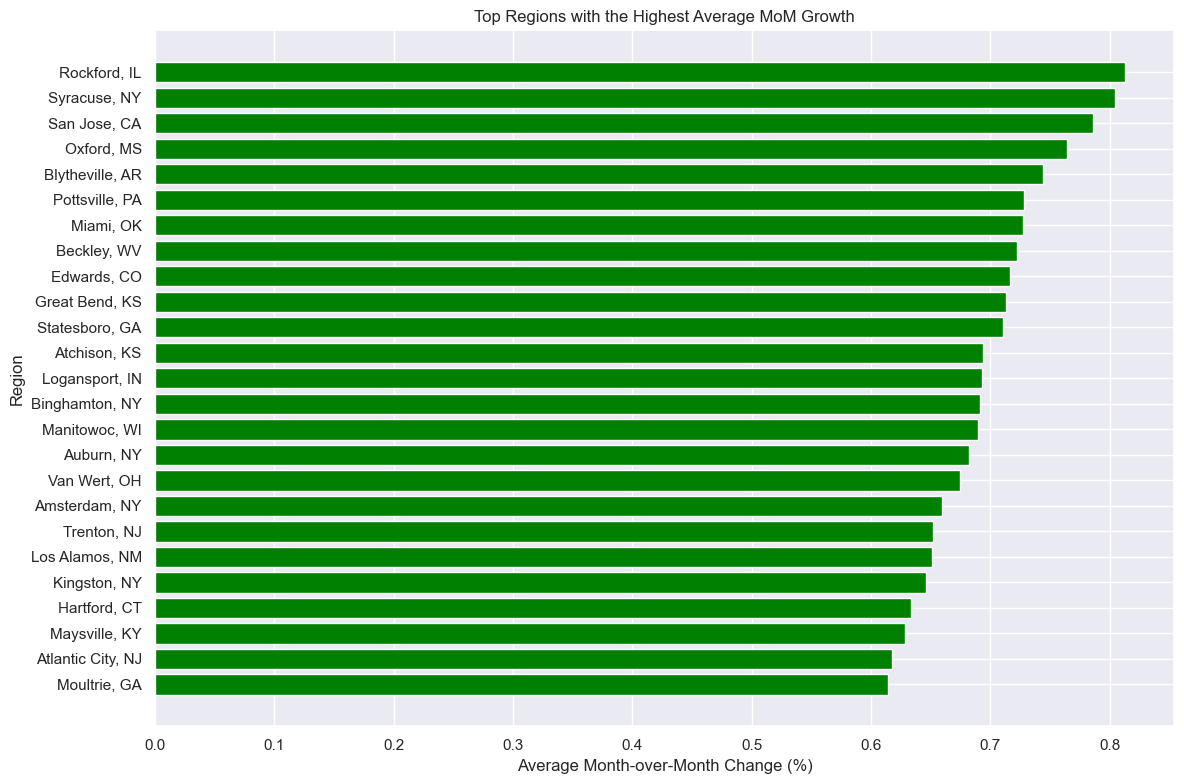

In [216]:
util.plot_top_regions_mom_change(top_25_regions)

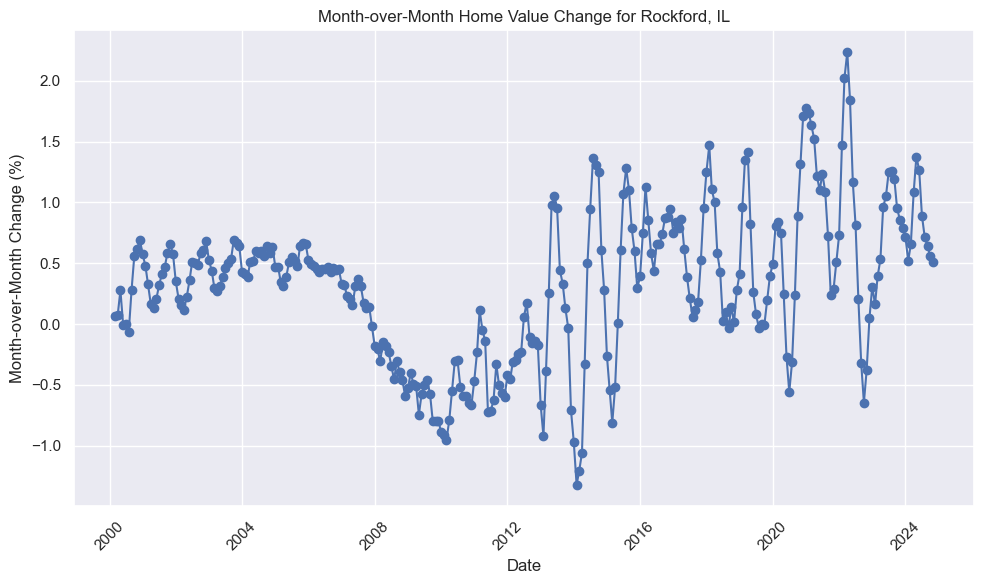

In [217]:
# Show top region entire history of MoM
util.plot_region_mom_change(single_home_values_final[single_home_values_final['RegionID'] == 395033], 'Rockford, IL')

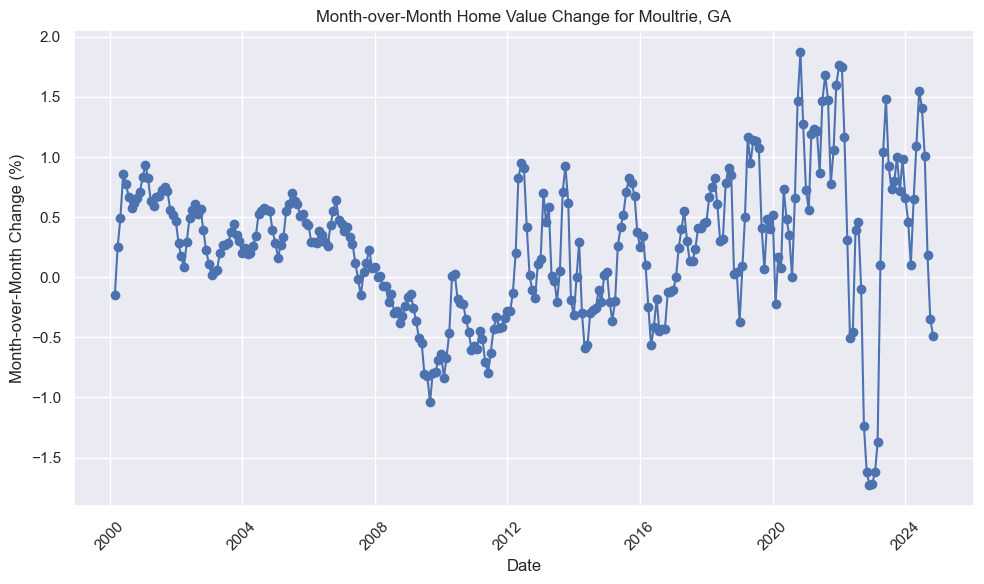

In [218]:
# Show bottom region entire history of MoM
# 394883	Moultrie, GA
util.plot_region_mom_change(single_home_values_final[single_home_values_final['RegionID'] == 394883], 'Moultrie, GA')

Above analysis shows upward trend for home values for the recent years. It also shows what we expect for the financial crisis of 2008 as home values tanked. Since COVID19, we see overall positive, and we expect better outlook for 2025 as the FED continues to cut down interest rates.

## Identifying Holding Period

Holding period is important for calculating many of our ROI parameters. For example, we need to know how long we're holding the unit for to calculate how much financing charges we would incur. Additionally, we need to know the sale date to identify the approximate property sell price. 

Parameters to calculate the holding period:
* **Renovation Time** this is the time we're using to upgrade the property.
* **Days-to-Pending** this is how long the unit is on the market for before a buyer makes an acceptable offer. We will use Zillow dataset to estimate. 
* **Days-to-Close** how many days elapsed since an offer has been accepted till the sale is finalized and legal papers are signed. We will use Zillow dataset to estimate.

We will use forecasted home value for October 31st, 2025 as our sale price to simplify our calculations. This leaves ample time for renovations. We still need Days-to-Pending and Days-to-Close to calculate how long we're holding the unit after we list on it on the market, on October 31st, 2025.

In [219]:
mean_days_to_pending = pd.read_csv('../data/Metro_mean_doz_pending_uc_sfrcondo_sm_month.csv')
mean_days_to_pending.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,102001,0,United States,country,NaN,51.0,48.0,45.0,43.0,44.0,...,49.0,52.0,49.0,43.0,39.0,37.0,38.0,41.0,44.0,46.0
1,394913,1,"New York, NY",msa,NY,68.0,65.0,63.0,64.0,66.0,...,68.0,71.0,67.0,58.0,51.0,49.0,49.0,52.0,55.0,58.0
2,753899,2,"Los Angeles, CA",msa,CA,35.0,32.0,31.0,32.0,33.0,...,40.0,41.0,37.0,33.0,30.0,29.0,30.0,33.0,36.0,38.0
3,394463,3,"Chicago, IL",msa,IL,51.0,44.0,40.0,39.0,40.0,...,42.0,43.0,38.0,31.0,26.0,24.0,24.0,25.0,28.0,31.0
4,394514,4,"Dallas, TX",msa,TX,46.0,42.0,38.0,37.0,38.0,...,51.0,52.0,49.0,43.0,39.0,38.0,40.0,45.0,50.0,54.0


In [220]:
# Let's format the data similar to our home value index data
mean_days_to_pending_melted = util.melt_zillow_dataset(mean_days_to_pending, id_fields=['RegionID', 'RegionName',	'StateName'], index_field='RegionName', fields_to_drop=['SizeRank', 'RegionType'], value_col='DaysToPending')
mean_days_to_pending_melted.head()

,RegionID,StateName,Date,DaysToPending
RegionName,,,,
"New York, NY",394913,NY,2018-03-31,68.0
"Los Angeles, CA",753899,CA,2018-03-31,35.0
"Chicago, IL",394463,IL,2018-03-31,51.0
"Dallas, TX",394514,TX,2018-03-31,46.0
"Houston, TX",394692,TX,2018-03-31,49.0


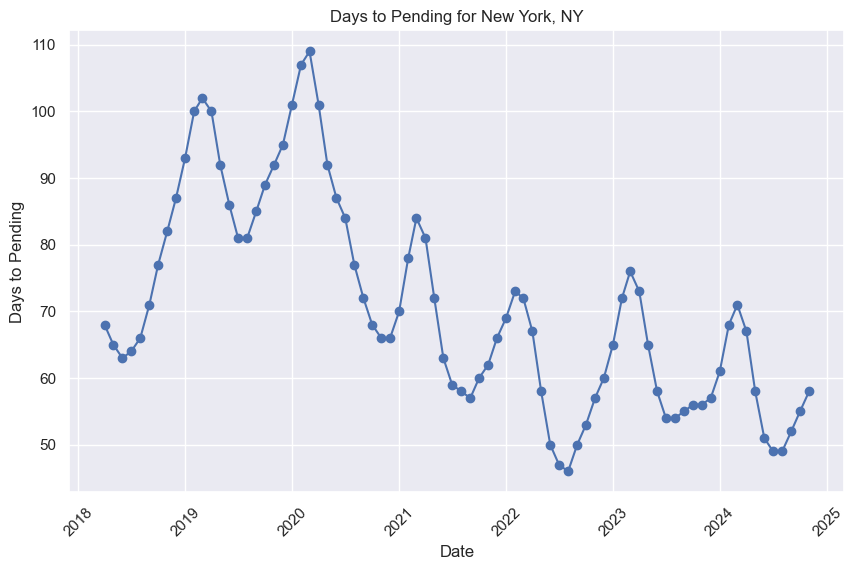

In [221]:
# Filter data for one region (e.g., 'New York, NY')
region_data = mean_days_to_pending_melted[mean_days_to_pending_melted['RegionID'] == 394913]

# Plot the timeline for this region
plt.figure(figsize=(10, 6))
plt.plot(region_data['Date'], region_data['DaysToPending'], marker='o', linestyle='-', color='b')
plt.title('Days to Pending for New York, NY')
plt.xlabel('Date')
plt.ylabel('Days to Pending')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

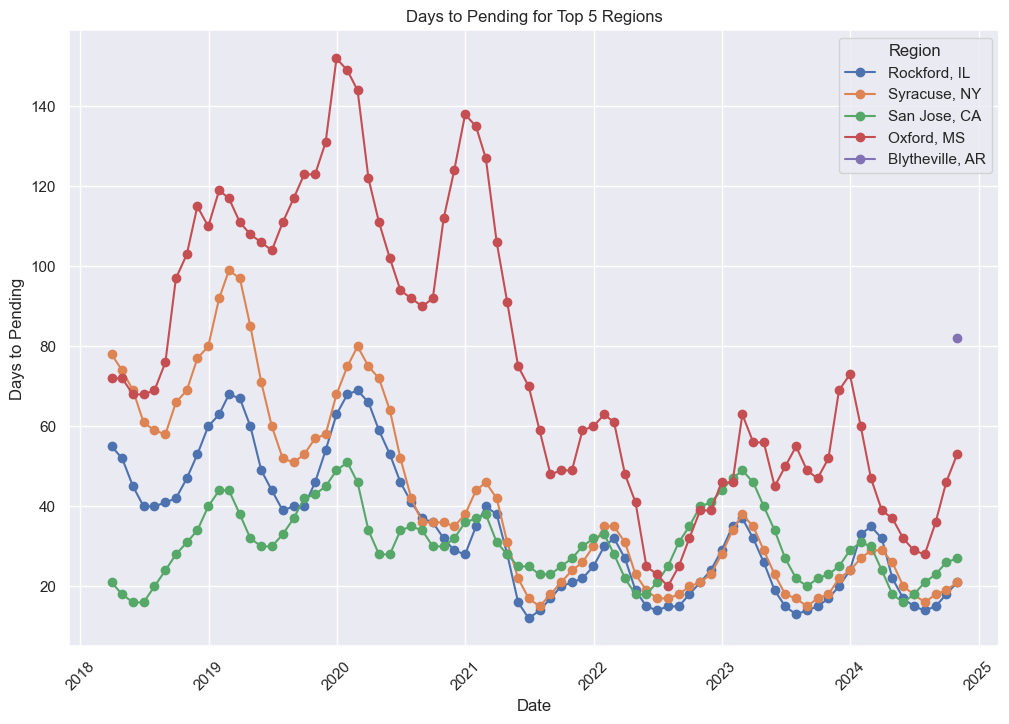

In [222]:
# Trends among our top ten regions
regions_to_plot = top_25_regions.head(5)['RegionID']
multiple_region_data = mean_days_to_pending_melted[mean_days_to_pending_melted['RegionID'].isin(regions_to_plot)].reset_index()

# Plot the timelines for multiple regions
plt.figure(figsize=(12, 8))

for region in regions_to_plot:
    region_data = multiple_region_data[multiple_region_data['RegionID'] == region]
    if not region_data.empty:
        plt.plot(region_data['Date'], region_data['DaysToPending'], marker='o', label=region_data['RegionName'].iloc[0])

plt.title('Days to Pending for Top 5 Regions')
plt.xlabel('Date')
plt.ylabel('Days to Pending')
plt.legend(title='Region')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [223]:
mean_days_to_close = pd.read_csv('../data/Metro_mean_days_to_close_uc_sfrcondo_sm_month.csv')
mean_days_to_close.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
0,102001,0,United States,country,NaN,35.0,34.0,34.0,35.0,36.0,...,33.0,34.0,34.0,33.0,32.0,33.0,34.0,34.0,34.0,34.0
1,394913,1,"New York, NY",msa,NY,57.0,53.0,50.0,51.0,53.0,...,53.0,54.0,55.0,54.0,52.0,51.0,53.0,54.0,55.0,55.0
2,753899,2,"Los Angeles, CA",msa,CA,34.0,32.0,33.0,33.0,34.0,...,30.0,31.0,30.0,30.0,29.0,29.0,29.0,29.0,29.0,30.0
3,394463,3,"Chicago, IL",msa,IL,43.0,42.0,42.0,44.0,45.0,...,37.0,38.0,37.0,37.0,36.0,37.0,38.0,38.0,38.0,37.0
4,394514,4,"Dallas, TX",msa,TX,21.0,21.0,21.0,22.0,22.0,...,28.0,28.0,28.0,28.0,28.0,28.0,29.0,29.0,29.0,28.0


In [224]:
mean_days_to_close_melted = util.melt_zillow_dataset(mean_days_to_close, id_fields=['RegionID', 'RegionName',	'StateName'], index_field='RegionName', fields_to_drop=['SizeRank', 'RegionType'], value_col='DaysToClose')
mean_days_to_close_melted.head()

,RegionID,StateName,Date,DaysToClose
RegionName,,,,
"New York, NY",394913,NY,2018-03-31,57.0
"Los Angeles, CA",753899,CA,2018-03-31,34.0
"Chicago, IL",394463,IL,2018-03-31,43.0
"Dallas, TX",394514,TX,2018-03-31,21.0
"Houston, TX",394692,TX,2018-03-31,31.0


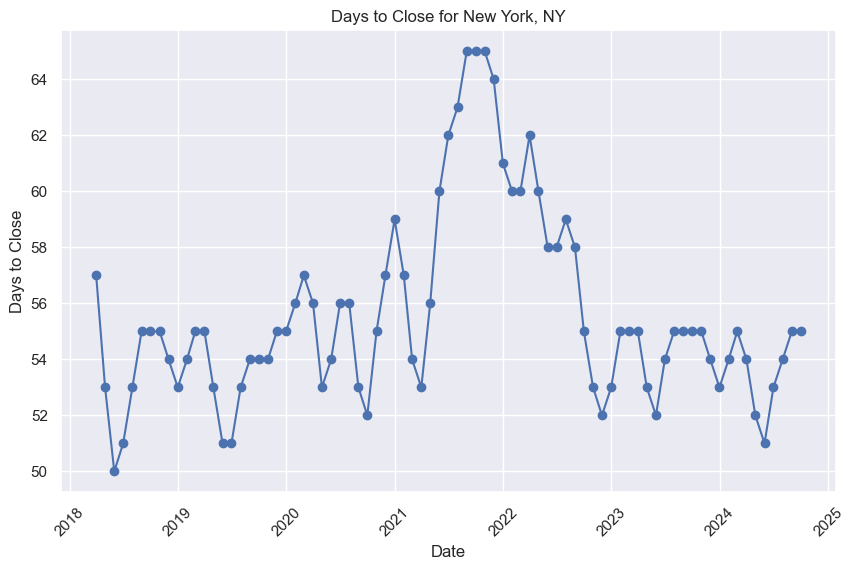

In [225]:
# Filter data for one region (e.g., 'New York, NY')
region_data = mean_days_to_close_melted[mean_days_to_close_melted['RegionID'] == 394913]

# Plot the timeline for this region
plt.figure(figsize=(10, 6))
plt.plot(region_data['Date'], region_data['DaysToClose'], marker='o', linestyle='-', color='b')
plt.title('Days to Close for New York, NY')
plt.xlabel('Date')
plt.ylabel('Days to Close')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

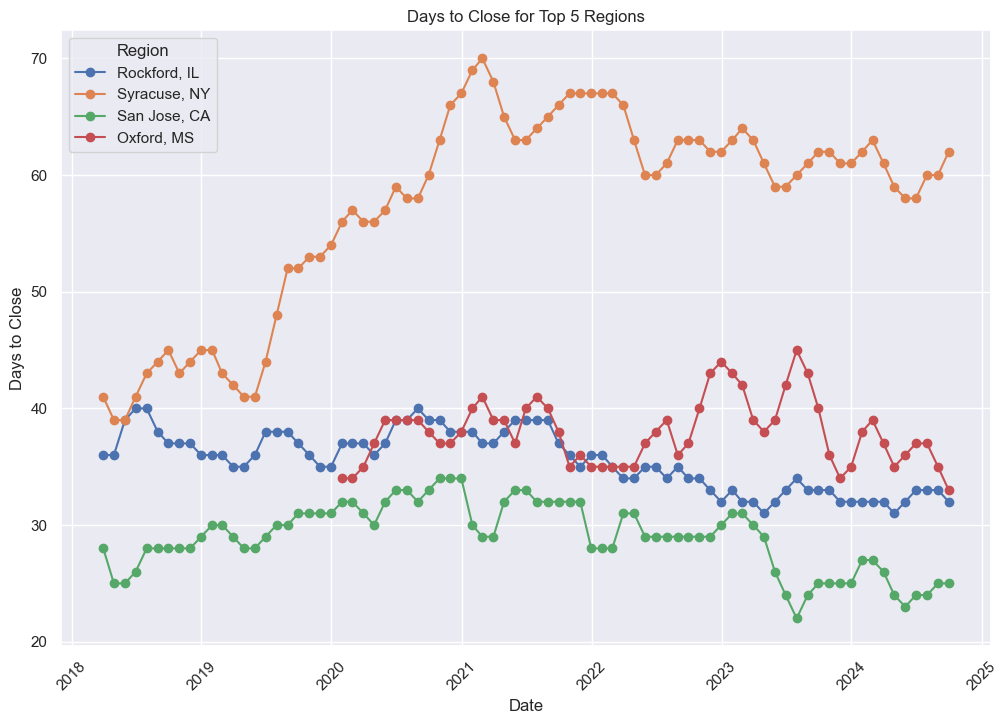

In [226]:
# Trends among our top ten regions
regions_to_plot = top_25_regions.head(5)['RegionID']
multiple_region_data = mean_days_to_close_melted[mean_days_to_close_melted['RegionID'].isin(regions_to_plot)].reset_index()

# Plot the timelines for multiple regions
plt.figure(figsize=(12, 8))

for region in regions_to_plot:
    region_data = multiple_region_data[multiple_region_data['RegionID'] == region]
    if not region_data.empty:
        plt.plot(region_data['Date'], region_data['DaysToClose'], marker='o', label=region_data['RegionName'].iloc[0])

plt.title('Days to Close for Top 5 Regions')
plt.xlabel('Date')
plt.ylabel('Days to Close')
plt.legend(title='Region')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

Analysis for Days-to-Pending and Days-to-Close reveals that we would hold the property for 3-5 months following the listing on the market. It also shows that some regions have little or no data for those two parameters, so we will use the mean to fill those gaps where they exist.

## How Much to Invest
With financing in the picture, we've the ability to invest in properties with value of $20 millions, but we've to keep cash around. Our investor is willing to invest \\$12 million, so let's discuss strategy. 

### Use 40% Equity-to-Value
For each property, we will put 40% down payment and take a mortgage for the remaining balance. We will take [interest-only mortgage loans](https://www.chase.com/personal/mortgage/education/financing-a-home/what-is-interest-only-mortgage) which works better for our investor use-case. Interest-Only mortgage means we will pay interest only and no payment toward the principle for x years. This makes our monthly payment smaller since we're holding the unit for a short period. Interest-only loans should offer a better APR. [We will assume interest rate of 6.558% as indicated on rate.com as of Dec 10th, 2024](https://www.rate.com/mortgage-rates).

### Keep Third of Our Cash
How much cash to keep on hand can be a complex calculation. We will try to simplify it and assume a 33.33% is enough to cover our expenses while we hold the properties. This means we can put $8 million toward equity.

## Buying the Properties
Time to buy our properties. We will make couple assumptions here to simplify the math:
- All properties are bought by Dec 31st, 2024.
- Zillow Home Value Index(ZHVI) accurately reflects purchase prices, and the index for October 31st, 2024 holds true for all of our purchases.
- We will assume the only initial cost of the purchase is reflected in ZHVI, so no taxes or buyer fee for example.

Above we calculated the MoM change for single family homes value in `single_home_values_final` This allows us to find the best regions with historically high MoM rates. We also want to utilize Zillow Home Value Forecast for our intended date to list the properties on the market, 2025-10-31. To acquire the best of the two, we will get the top 50 regions with MoM change in the past year and reduce the list based on the Zillow forecast.

In [227]:
home_value_forecast = pd.read_csv('../data/forecast_metro.csv')
home_value_forecast.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,BaseDate,2024-11-30,2025-01-31,2025-10-31
0,102001,0,United States,country,NaN,2024-10-31,-0.4,-1.0,2.8
1,394913,1,"New York, NY",msa,NY,2024-10-31,-0.5,-0.8,1.1
2,753899,2,"Los Angeles, CA",msa,CA,2024-10-31,-0.7,-0.8,2.2
3,394463,3,"Chicago, IL",msa,IL,2024-10-31,-1.0,-2.2,0.7
4,394514,4,"Dallas, TX",msa,TX,2024-10-31,-1.1,-2.1,1.3


In [228]:
# Melt the data and only keep the YoY projection for 2025-10-31
home_value_forecast = util.melt_zillow_dataset(home_value_forecast, id_fields=['RegionID'], fields_to_drop=['SizeRank', 'RegionName', 'RegionType', 'StateName', 'BaseDate', '2024-11-30', '2025-01-31'], date_col='ForecastDate', value_col='ForecastChange')
home_value_forecast.head()

,RegionID,ForecastDate,ForecastChange
0,394913,2025-10-31,1.1
1,753899,2025-10-31,2.2
2,394463,2025-10-31,0.7
3,394514,2025-10-31,1.3
4,394692,2025-10-31,0.8


In [229]:
top_50_regions = util.get_top_regions_by_mom_change(single_home_values_final, top_n=50)
regions_to_buy_from = top_50_regions.merge(home_value_forecast, on=['RegionID'], how='inner')
regions_to_buy_from.head()

,RegionID,RegionName,MoM_Change,ForecastDate,ForecastChange
0,395033,"Rockford, IL",0.813178,2025-10-31,3.4
1,395143,"Syracuse, NY",0.804417,2025-10-31,3.9
2,395059,"San Jose, CA",0.786331,2025-10-31,0.0
3,394951,"Oxford, MS",0.764303,2025-10-31,3.7
4,394397,"Blytheville, AR",0.744494,2025-10-31,-0.8


In [230]:
# As we see above using MoM change may be at odds with Zillow projections for the same regions.
# Let's drop any region with negative forecast and sort them by the forecast change in value
regions_to_buy_from = regions_to_buy_from[regions_to_buy_from['ForecastChange'] > 0]
regions_to_buy_from = regions_to_buy_from.sort_values(by='ForecastChange', ascending=False)
regions_to_buy_from.head()

,RegionID,RegionName,MoM_Change,ForecastDate,ForecastChange
48,395154,"Thomaston, GA",0.569473,2025-10-31,7.8
8,394556,"Edwards, CO",0.716400,2025-10-31,7.1
26,753921,"Steamboat Springs, CO",0.612016,2025-10-31,6.8
23,394348,"Atlantic City, NJ",0.617399,2025-10-31,6.6
20,394748,"Kingston, NY",0.646099,2025-10-31,6.1


In [231]:
# Let's add the purchase price to our data frame. Following our assumption above, we're using the 2024-10-31 estimation 
target_date = pd.to_datetime('2024-10-31')

# Filter single_home_values_final for the specified EestimationDate
filtered_home_values = single_home_values_final[single_home_values_final['EestimationDate'] == target_date]

regions_to_buy_from = regions_to_buy_from.merge(filtered_home_values[['RegionID', 'HomeValue']], on=['RegionID'], how='left')
regions_to_buy_from.rename(columns={'HomeValue': 'PurchaseCost'}, inplace=True)
regions_to_buy_from.head()

,RegionID,RegionName,MoM_Change,ForecastDate,ForecastChange,PurchaseCost
0,395154,"Thomaston, GA",0.569473,2025-10-31,7.8,1.747448e+05
1,394556,"Edwards, CO",0.716400,2025-10-31,7.1,1.535533e+06
2,753921,"Steamboat Springs, CO",0.612016,2025-10-31,6.8,1.312827e+06
3,394348,"Atlantic City, NJ",0.617399,2025-10-31,6.6,3.890825e+05
4,394748,"Kingston, NY",0.646099,2025-10-31,6.1,4.190990e+05


In [232]:
# Only buy from top 5 regions with the best projected appreciation
bought_properties = regions_to_buy_from.head().copy()

# Budget available (in dollars). 40% cash are $9 million and the rest is financed
budget = (8_000_000 / 0.4)

# Track total payments
total_payments = 0

# Initialize a new column for the number of properties purchased per region
bought_properties['NumberOfProperties'] = 0

# Loop through the properties until the budget is exhausted
while total_payments <= budget:
    for index, row in bought_properties.iterrows():
        if total_payments + row['PurchaseCost'] <= budget:
            bought_properties.loc[index, 'NumberOfProperties'] = row['NumberOfProperties'] + 1
            total_payments += row['PurchaseCost']
        else:
            break
    else:
        continue
    break

# Above loop will break before we hit the budget, let's see if the remaining amount can afford us a few cheap properties
while bought_properties['PurchaseCost'].min() < (budget - total_payments):
    index = bought_properties['PurchaseCost'].idxmin()
    total_payments += bought_properties.loc[index, 'PurchaseCost']
    bought_properties.loc[index, 'NumberOfProperties'] = bought_properties.loc[index,'NumberOfProperties'] + 1

# Result: The properties we can afford and the total payments used
print(f"Total budget: ${budget:,.2f}")
print(f"Total payments used: ${total_payments:,.2f}")
print(f"Remaining budget: ${budget - total_payments:,.2f}")
bought_properties.head()

Total budget: $20,000,000.00
Total payments used: $19,855,410.80
Remaining budget: $144,589.20


,RegionID,RegionName,MoM_Change,ForecastDate,ForecastChange,PurchaseCost,NumberOfProperties
0,395154,"Thomaston, GA",0.569473,2025-10-31,7.8,1.747448e+05,9
1,394556,"Edwards, CO",0.716400,2025-10-31,7.1,1.535533e+06,5
2,753921,"Steamboat Springs, CO",0.612016,2025-10-31,6.8,1.312827e+06,5
3,394348,"Atlantic City, NJ",0.617399,2025-10-31,6.6,3.890825e+05,5
4,394748,"Kingston, NY",0.646099,2025-10-31,6.1,4.190990e+05,5


## Calculate Total Investment & Net Profit
Let's calculate all costs associated with our investment.

### Purchase & Financing Costs
Purchase cost is how much we put down out of our pocket. Financing cost is how much interest we're paying.

In [233]:
# Now, let's add columns for the cost of purchase
bought_properties['DownPayments'] = (bought_properties['PurchaseCost'] * .40) * bought_properties['NumberOfProperties'] 
bought_properties['LoanTotal'] = (bought_properties['PurchaseCost'] * .60) * bought_properties['NumberOfProperties']

# With interest rate of 6.558%, calculate monthly interest
bought_properties['InterestPerMonth'] = bought_properties['LoanTotal'] * (.06558/12)

print(f"Total Purchase Costs: ${bought_properties['DownPayments'].sum():,.2f}")
print(f"Financing Costs per Month: ${bought_properties['InterestPerMonth'].sum():,.2f}")
bought_properties.head()

Total Purchase Costs: $7,942,164.32
Financing Costs per Month: $65,105.89


,RegionID,RegionName,MoM_Change,ForecastDate,ForecastChange,PurchaseCost,NumberOfProperties,DownPayments,LoanTotal,InterestPerMonth
0,395154,"Thomaston, GA",0.569473,2025-10-31,7.8,1.747448e+05,9,6.290814e+05,9.436221e+05,5156.894582
1,394556,"Edwards, CO",0.716400,2025-10-31,7.1,1.535533e+06,5,3.071065e+06,4.606598e+06,25175.057368
2,753921,"Steamboat Springs, CO",0.612016,2025-10-31,6.8,1.312827e+06,5,2.625655e+06,3.938482e+06,21523.804125
3,394348,"Atlantic City, NJ",0.617399,2025-10-31,6.6,3.890825e+05,5,7.781650e+05,1.167247e+06,6379.007478
4,394748,"Kingston, NY",0.646099,2025-10-31,6.1,4.190990e+05,5,8.381980e+05,1.257297e+06,6871.128449


### Holding Costs
To calculate holding costs, we need to know how long we will own the property. Based on a [study from BankRate](https://www.bankrate.com/mortgages/hidden-costs-of-homeownership-study/), the average cost of owning a single family home soared to $18,000 in 2024. We will assume a fixed amount of \\$18,000 per year. 

To calculate how long we will own the properties, we will need the mean Days-to-Pending and Days-to-Close. We assume that we will list the properties on the market for sale on October 31st, 2025.

In [234]:
# Create temp data frame with days to pending and days to close to calculate sale date
sale_data = bought_properties.merge(mean_days_to_pending_melted.groupby('RegionID')['DaysToPending'].mean(), on=['RegionID'], how='left')
# Fill using mean if any is missing
sale_data.fillna(sale_data['DaysToPending'].mean(), inplace=True)

sale_data = sale_data.merge(mean_days_to_close_melted.groupby('RegionID')['DaysToClose'].mean(), on=['RegionID'], how='left')
# Fill using mean if any is missing
sale_data.fillna(sale_data['DaysToClose'].mean(), inplace=True)
sale_data.head()

,RegionID,RegionName,MoM_Change,ForecastDate,ForecastChange,PurchaseCost,NumberOfProperties,DownPayments,LoanTotal,InterestPerMonth,DaysToPending,DaysToClose
0,395154,"Thomaston, GA",0.569473,2025-10-31,7.8,1.747448e+05,9,6.290814e+05,9.436221e+05,5156.894582,51.000000,42.444255
1,394556,"Edwards, CO",0.716400,2025-10-31,7.1,1.535533e+06,5,3.071065e+06,4.606598e+06,25175.057368,64.759259,41.134615
2,753921,"Steamboat Springs, CO",0.612016,2025-10-31,6.8,1.312827e+06,5,2.625655e+06,3.938482e+06,21523.804125,56.000000,38.250000
3,394348,"Atlantic City, NJ",0.617399,2025-10-31,6.6,3.890825e+05,5,7.781650e+05,1.167247e+06,6379.007478,68.512500,40.164557
4,394748,"Kingston, NY",0.646099,2025-10-31,6.1,4.190990e+05,5,8.381980e+05,1.257297e+06,6871.128449,83.387500,50.227848


In [235]:
# Calculate the sale date. Starting from the list date
market_list_date = pd.to_datetime('2025-10-31')
sale_data['SaleDate'] = market_list_date + pd.to_timedelta(sale_data['DaysToPending'] + sale_data['DaysToClose'], unit='day')
sale_data.head()

,RegionID,RegionName,MoM_Change,ForecastDate,ForecastChange,PurchaseCost,NumberOfProperties,DownPayments,LoanTotal,InterestPerMonth,DaysToPending,DaysToClose,SaleDate
0,395154,"Thomaston, GA",0.569473,2025-10-31,7.8,1.747448e+05,9,6.290814e+05,9.436221e+05,5156.894582,51.000000,42.444255,2026-02-01 10:39:43.641674778
1,394556,"Edwards, CO",0.716400,2025-10-31,7.1,1.535533e+06,5,3.071065e+06,4.606598e+06,25175.057368,64.759259,41.134615,2026-02-13 21:27:10.769230765
2,753921,"Steamboat Springs, CO",0.612016,2025-10-31,6.8,1.312827e+06,5,2.625655e+06,3.938482e+06,21523.804125,56.000000,38.250000,2026-02-02 06:00:00.000000000
3,394348,"Atlantic City, NJ",0.617399,2025-10-31,6.6,3.890825e+05,5,7.781650e+05,1.167247e+06,6379.007478,68.512500,40.164557,2026-02-16 16:14:57.721518985
4,394748,"Kingston, NY",0.646099,2025-10-31,6.1,4.190990e+05,5,8.381980e+05,1.257297e+06,6871.128449,83.387500,50.227848,2026-03-13 14:46:06.075949365


In [236]:
# We own the properties starting in first day of 2025.
purchase_period = pd.to_datetime('2025-01-01').to_period('M')
sale_data['HoldingMonths'] = (sale_data['SaleDate'].dt.to_period('M') - purchase_period).apply(lambda x: x.n)

# Holding cost per month
sale_data['HoldingCostsPerMonth'] = (18_000/12) * sale_data['NumberOfProperties']
print(f"Holding Costs per Month: ${sale_data['HoldingCostsPerMonth'].sum():,.2f}")
sale_data.head()

Holding Costs per Month: $43,500.00


,RegionID,RegionName,MoM_Change,ForecastDate,ForecastChange,PurchaseCost,NumberOfProperties,DownPayments,LoanTotal,InterestPerMonth,DaysToPending,DaysToClose,SaleDate,HoldingMonths,HoldingCostsPerMonth
0,395154,"Thomaston, GA",0.569473,2025-10-31,7.8,1.747448e+05,9,6.290814e+05,9.436221e+05,5156.894582,51.000000,42.444255,2026-02-01 10:39:43.641674778,13,13500.0
1,394556,"Edwards, CO",0.716400,2025-10-31,7.1,1.535533e+06,5,3.071065e+06,4.606598e+06,25175.057368,64.759259,41.134615,2026-02-13 21:27:10.769230765,13,7500.0
2,753921,"Steamboat Springs, CO",0.612016,2025-10-31,6.8,1.312827e+06,5,2.625655e+06,3.938482e+06,21523.804125,56.000000,38.250000,2026-02-02 06:00:00.000000000,13,7500.0
3,394348,"Atlantic City, NJ",0.617399,2025-10-31,6.6,3.890825e+05,5,7.781650e+05,1.167247e+06,6379.007478,68.512500,40.164557,2026-02-16 16:14:57.721518985,13,7500.0
4,394748,"Kingston, NY",0.646099,2025-10-31,6.1,4.190990e+05,5,8.381980e+05,1.257297e+06,6871.128449,83.387500,50.227848,2026-03-13 14:46:06.075949365,14,7500.0


### Renovation Costs
For renovations, investors only spend on upgrades to recoup resale value increase. We will assume our investor is spending around 10% of the property value on renovation. Additionally, we will guide our investor on which renovations to do using data from [the Journal for Light Construction data](https://www.jlconline.com/cost-vs-value/2024/) in 2024. We will assume recoup rate of 125% of the renovations costs in resale value.

In [237]:
# Using 10% of the unit value when buying it to calculate the renovation costs per region
sale_data['RenovationCost'] = sale_data['PurchaseCost'] * 0.1
sale_data['ResaleValueIncrease'] = sale_data['RenovationCost'] * 1.25
print(f"Total Renovation Costs: ${(sale_data['RenovationCost'] * sale_data['NumberOfProperties']).sum():,.2f}")
print(f"Total Resale Value Increase: ${(sale_data['ResaleValueIncrease']  * sale_data['NumberOfProperties']).sum():,.2f}")
sale_data[['RegionID', 'RegionName', 'PurchaseCost', 'NumberOfProperties', 'RenovationCost', 'ResaleValueIncrease']].head()

Total Renovation Costs: $1,985,541.08
Total Resale Value Increase: $2,481,926.35


,RegionID,RegionName,PurchaseCost,NumberOfProperties,RenovationCost,ResaleValueIncrease
0,395154,"Thomaston, GA",1.747448e+05,9,17474.482674,21843.103343
1,394556,"Edwards, CO",1.535533e+06,5,153553.262385,191941.577982
2,753921,"Steamboat Springs, CO",1.312827e+06,5,131282.733302,164103.416628
3,394348,"Atlantic City, NJ",3.890825e+05,5,38908.249331,48635.311664
4,394748,"Kingston, NY",4.190990e+05,5,41909.902101,52387.377626


### Sale Price & Costs
Now, it's time to calculate our sale price and selling costs as our last two parameters. We will assume selling costs us 3% of the ask price.

In [238]:
sale_data['SalePrice'] = sale_data['PurchaseCost'] + (sale_data['PurchaseCost'] * (sale_data['ForecastChange']/100)) + sale_data['ResaleValueIncrease']
sale_data['SellingCosts'] = sale_data['SalePrice'] * 0.03 * sale_data['NumberOfProperties']
print(f"Total Selling Costs: ${sale_data['SellingCosts'].sum():,.2f}")
sale_data.head()

Total Selling Costs: $711,231.17


,RegionID,RegionName,MoM_Change,ForecastDate,ForecastChange,PurchaseCost,NumberOfProperties,DownPayments,LoanTotal,InterestPerMonth,DaysToPending,DaysToClose,SaleDate,HoldingMonths,HoldingCostsPerMonth,RenovationCost,ResaleValueIncrease,SalePrice,SellingCosts
0,395154,"Thomaston, GA",0.569473,2025-10-31,7.8,1.747448e+05,9,6.290814e+05,9.436221e+05,5156.894582,51.000000,42.444255,2026-02-01 10:39:43.641674778,13,13500.0,17474.482674,21843.103343,2.102180e+05,56758.867175
1,394556,"Edwards, CO",0.716400,2025-10-31,7.1,1.535533e+06,5,3.071065e+06,4.606598e+06,25175.057368,64.759259,41.134615,2026-02-13 21:27:10.769230765,13,7500.0,153553.262385,191941.577982,1.836497e+06,275474.552720
2,753921,"Steamboat Springs, CO",0.612016,2025-10-31,6.8,1.312827e+06,5,2.625655e+06,3.938482e+06,21523.804125,56.000000,38.250000,2026-02-02 06:00:00.000000000,13,7500.0,131282.733302,164103.416628,1.566203e+06,234930.451245
3,394348,"Atlantic City, NJ",0.617399,2025-10-31,6.6,3.890825e+05,5,7.781650e+05,1.167247e+06,6379.007478,68.512500,40.164557,2026-02-16 16:14:57.721518985,13,7500.0,38908.249331,48635.311664,4.633972e+05,69509.587430
4,394748,"Kingston, NY",0.646099,2025-10-31,6.1,4.190990e+05,5,8.381980e+05,1.257297e+06,6871.128449,83.387500,50.227848,2026-03-13 14:46:06.075949365,14,7500.0,41909.902101,52387.377626,4.970514e+05,74557.715837


### Calculate Total Investment & Net Profit
Let's now calculate our total investment and net profit. 

**Total Investment = Down Payments + Renovation Costs + Holding Costs + Financing Costs + Selling Costs**


**Net Profit = Total Sales - Total Investment - Loans Repayment**

Total Investment: $12,065,184.30


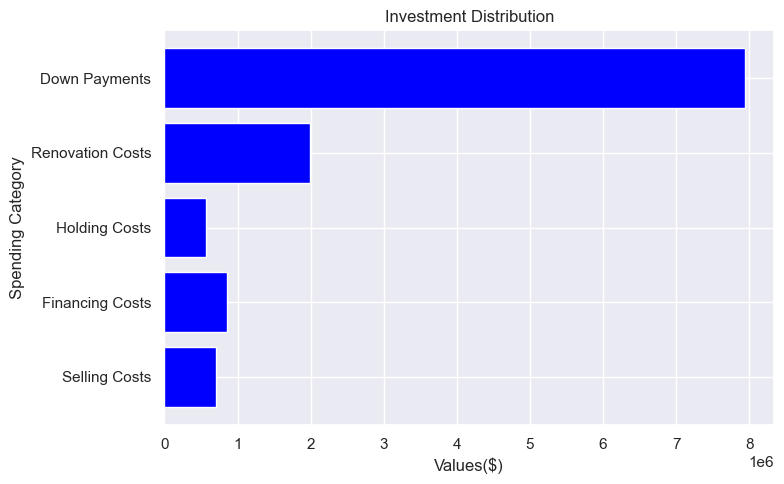

In [239]:
# Down payments
total_investment = sale_data['DownPayments'].sum() 
# Renovation costs
total_investment += (sale_data['RenovationCost'] * sale_data['NumberOfProperties']).sum()
# Holding costs
total_investment += (sale_data['HoldingCostsPerMonth'] * sale_data['HoldingMonths']).sum()
# Financing costs
total_investment += (sale_data['InterestPerMonth'] * sale_data['HoldingMonths']).sum()
# Selling costs
total_investment += sale_data['SellingCosts'].sum()

print(f"Total Investment: ${total_investment:,.2f}")

# Data for the bar chart
categories = ['Down Payments', 'Renovation Costs', 'Holding Costs', 'Financing Costs', 'Selling Costs']
values = [sale_data['DownPayments'].sum(),
          (sale_data['RenovationCost'] * sale_data['NumberOfProperties']).sum(),
          (sale_data['HoldingCostsPerMonth'] * sale_data['HoldingMonths']).sum(),
          (sale_data['InterestPerMonth'] * sale_data['HoldingMonths']).sum(),
          sale_data['SellingCosts'].sum()]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.barh(categories, values, color='blue')

# Customize labels and title
plt.xlabel('Values($)')
plt.ylabel('Spending Category')
plt.title('Investment Distribution')
plt.gca().invert_yaxis()
plt.tight_layout()
# Display the chart
plt.show()

Based on the total investment above, we went slightly over our budget of $12 million. This means that our initial estimation of keeping third of our cash falls short of the actual expenses. We can easily change the number above, but we will continue with our analysis. 

In [240]:
total_sales = (sale_data['SalePrice'] * sale_data['NumberOfProperties']).sum()
total_loan_repayment = sale_data['LoanTotal'].sum()
net_profit = total_sales - total_investment - total_loan_repayment
print(f"Total Sales: ${total_sales:,.2f}")
print(f"Total Loan Repayment: ${total_loan_repayment:,.2f}")
print(f"Net Profit: ${net_profit:,.2f}")

Total Sales: $23,707,705.81
Total Loan Repayment: $11,913,246.48
Net Profit: $-270,724.96


## Return on Investment
Our return on investment is simply the ratio of net profit to total investment. The numbers already tell us that we're losing money. Let's see this in terms of ROI

In [241]:
roi = (net_profit / total_investment) * 100
print(f"Return on Investment: {roi:,.2f}%")

Return on Investment: -2.24%


## Conclusion
Flipping properties might not be the best investment at the current market. This is driven by [multiple factors](https://www.nasdaq.com/articles/now-good-time-invest-real-estate) including:
* High interest rate. Interest rate was the our highest expense while holding the properties.
* Low affordability. Many now are unable to afford buying property, so they opt to renting rather than buying.

If we can offset the financing and holding costs by for example renting the properties, this investment would work very well. Otherwise, even at 7% YoY appreciation, flipping homes may not be a good investment.